## MM2020 GW - without USSN and ECSN

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
77 77 77 77 77 77
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020/data_10.0.csv
total masses


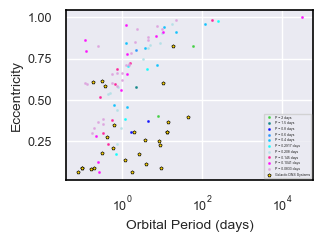

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 400  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    # if remnant_type == 'NS':
    #     if core_mass_CO < M1:
    #         remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
    #     elif M1 <= core_mass_CO < M2:
    #         µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
    #         remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
    #     elif M2 <= core_mass_CO < M3:
    #         µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
    #         remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       #if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        #kick_velocity = 30
       #else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           #if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
            # kick_velocity /= 3
             
           #if core_mass_CO >= 1.9:
           # kick_velocity *= 3   
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 + Kapil et al. - without USSN and ECSN 

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
36 36 36 36 36 36
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal/data_10.0.csv
total masses


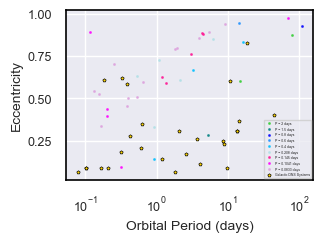

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    if remnant_type == 'NS':
         if core_mass_CO < M1:
             remnant_mass = max(min(np.random.normal(µ1, σ1), MNS_max), MNS_min)
         elif M1 <= core_mass_CO < M2:
             µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
             remnant_mass = max(min(np.random.normal(µ, σ2), MNS_max), MNS_min)
         elif M2 <= core_mass_CO < M3:
             µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
             remnant_mass = max(min(np.random.normal(µ, σ3), MNS_max), MNS_min)
                            
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       #if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        #kick_velocity = 30
       #else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           #if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
            # kick_velocity /= 3
             
           #if core_mass_CO >= 1.9:
           # kick_velocity *= 3   
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 + Kapil + USSN + ECSN

CO core mass: 1.20 Msun
CO core mass: 1.19 Msun
CO core mass: 1.16 Msun
CO core mass: 1.04 Msun
CO core mass: 1.22 Msun
CO core mass: 1.19 Msun
CO core mass: 1.19 Msun
CO core mass: 1.18 Msun
CO core mass: 1.19 Msun
CO core mass: 1.13 Msun
CO core mass: 1.20 Msun
CO core mass: 1.19 Msun
CO core mass: 1.20 Msun
CO core mass: 1.17 Msun
CO core mass: 1.10 Msun
CO core mass: 1.16 Msun
CO core mass: 1.07 Msun
CO core mass: 1.19 Msun
CO core mass: 1.19 Msun
CO core mass: 1.16 Msun
CO core mass: 1.19 Msun
CO core mass: 1.18 Msun
22000 22000 22000 22000 22000 22000
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn/data_2.5.csv
total masses


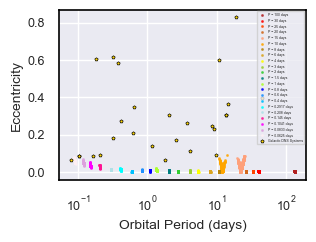

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn/data_2.5Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    # if remnant_type == 'NS':
    #     if core_mass_CO < M1:
    #         remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
    #     elif M1 <= core_mass_CO < M2:
    #         µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
    #         remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
    #     elif M2 <= core_mass_CO < M3:
    #         µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
    #         remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.43:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.43):
             kick_velocity /= 3
               
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [2.5] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 +kapil + USSN + ECSN (change to 1.44)

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
36 36 36 36 36 36
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn_1.44/data_10.0.csv
total masses


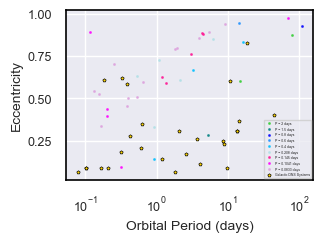

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn_1.44/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [188]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    if remnant_type == 'NS':
         if core_mass_CO < M1:
             remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
         elif M1 <= core_mass_CO < M2:
             µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
             remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
         elif M2 <= core_mass_CO < M3:
             µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
             remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    #if remnant_type == 'NS':
     #   if core_mass_CO < M1:
     #       remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
     #   elif M1 <= core_mass_CO < M2:
     #       µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
     #       remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
     #   elif M2 <= core_mass_CO < M3:
     #       µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
     #       remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
             kick_velocity /= 3
               
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn_1.44/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn_1.44/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020(mu2b 0.3) +kapil + USSN + ECSN (change to 1.44) 

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
36 36 36 36 36 36
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_mu2b0.3_Kapil_etal_ussn_ecsn_1.43/data_10.0.csv
total masses


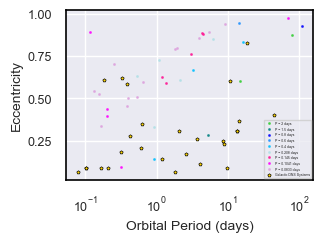

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_mu2b0.3_Kapil_etal_ussn_ecsn_1.43/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.3  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    if remnant_type == 'NS':
         if core_mass_CO < M1:
             remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
         elif M1 <= core_mass_CO < M2:
             µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
             remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
         elif M2 <= core_mass_CO < M3:
             µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
             remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    #if remnant_type == 'NS':
     #   if core_mass_CO < M1:
     #       remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
     #   elif M1 <= core_mass_CO < M2:
     #       µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
     #       remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
     #   elif M2 <= core_mass_CO < M3:
     #       µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
     #       remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.43:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.43):
             kick_velocity /= 3
               
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_mu2b0.3_Kapil_etal_ussn_ecsn_1.43/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_mu2b0.3_Kapil_etal_ussn_ecsn_1.43/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 + Kapil + USSN + ECSN + Kick factor x3

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
3 3 3 3 3 3
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn1.44_CO1.6_vk2/data_10.0.csv
total masses


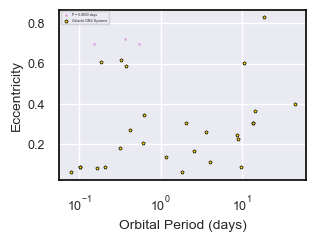

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn1.44_CO1.6_vk2/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [254]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    # if remnant_type == 'NS':
    #     if core_mass_CO < M1:
    #         remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
    #     elif M1 <= core_mass_CO < M2:
    #         µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
    #         remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
    #     elif M2 <= core_mass_CO < M3:
    #         µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
    #         remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
             kick_velocity /= 3
             
           if core_mass_CO >= 1.6:
            kick_velocity *= 2   
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn1.44_CO1.6_vk2/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn1.44_CO1.6_vk2/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 + Kapil + USSN + ECSN (change) + Kick factor 

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
0 0 0 0 0 0
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn1.44_vk3/data_10.0.csv
total masses


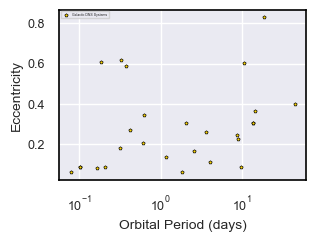

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn1.44_vk3/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.5  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    # if remnant_type == 'NS':
    #     if core_mass_CO < M1:
    #         remnant_mass = max(min(np.random.normal(µ1, σ1**2), MNS_max), MNS_min)
    #     elif M1 <= core_mass_CO < M2:
    #         µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
    #         remnant_mass = max(min(np.random.normal(µ, σ2**2), MNS_max), MNS_min)
    #     elif M2 <= core_mass_CO < M3:
    #         µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
    #         remnant_mass = max(min(np.random.normal(µ, σ3**2), MNS_max), MNS_min)
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = (np.random.normal(µ1, σ1**2))#, MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = (np.random.normal(µ, σ2**2))#, MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = (np.random.normal(µ, σ3**2))#, MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
             kick_velocity /= 3
             
           if core_mass_CO >= 1.9:
            kick_velocity *= 3   
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_Kapil_etal_ussn_ecsn1.44_vk3/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_Kapil_etal_ussn_ecsn1.44_vk3/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

## MM2020 (change mu2b) + Kapil + USSN + ECSN + kick factor
MU2B 0.3 + X2, 0.1 

CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
CO core mass: 5.57 Msun
3 3 3 3 3 3
Data saved as /Users/ashwathinair/Trials with kick and e/CSV/MM2020_MU2B0.1_Kapil_etal_ussn_CO1.6_ecsn1.44_vk2/data_10.0.csv
total masses


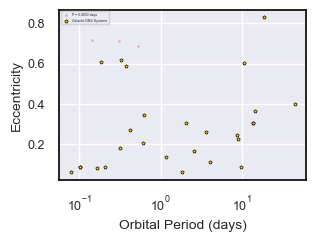

Plot saved as /Users/ashwathinair/Trials with kick and e/Plots/MM2020_MU2B0.1_Kapil_etal_ussn_C01.6_ecsn1.44_vk2/data_10.0Msun.png


<Figure size 332.1x258.3 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):
    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_star_mass = h.data('star_mass')[0]
    return final_mass_CO_core, final_star_mass, final_separation, initial_star_mass

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.1  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525  # NS kick scaling prefactor in km/s
    vBH = 200 #BH kick scaling factor in km/s
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = max(min(np.random.normal(µ1, σ1), MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = max(min(np.random.normal(µ, σ2), MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = max(min(np.random.normal(µ, σ3), MNS_max), MNS_min)                           
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
             kick_velocity /= 3
             
           if core_mass_CO >= 1.6:
            kick_velocity *= 2   
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/MM2020_MU2B0.1_Kapil_etal_ussn_C01.6_ecsn1.44_vk2/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/MM2020_MU2B0.1_Kapil_etal_ussn_CO1.6_ecsn1.44_vk2/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [10.0] # Add other masses if needed
desired_periods = ['0.0625', '0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5': 'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
orbital_periods = []
eccentricities = []

remnant_masses = []
kick_velocities = []

total_masses = []
initial_star_masses=[]

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, initial_separation, initial_star_mass = get_core_masses_and_separation(history_path)
            print( f"CO core mass: {final_CO:.2f} Msun")
            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                #remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                #print ({remnant_mass})
                #total_mass = m2.to(u.Msun).value + remnant_mass
                #print (f"remnant masses {remnant_mass}")
                #print (f"m2 {m2}")
               
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    
                    #print(f"Remnant type: {remnant_type}, Remnant mass: {remnant_mass:.2f} Msun")
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)# Calculate orbital period and convert to days
                            
                            #if orbital_period.value > 20:
                                 #if not printedB:
                                     #print("Wide orbit system found with Porb > 20 days!")
                                     #printedB = True
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            results_by_period[period]['kick_velocities'].append(vkick)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

#wide_orbits_count = sum(1 for p in orbital_periods if p > 20)
#print(f"Number of systems with Porb > 20 days: {wide_orbits_count}")

print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 
print(f"total masses") 
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))

for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.2, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")
# Close the plot to prevent overlap in the next iteration
#plt.close()

# modified_for_recycled

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):

    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    initial_star_mass = h.data('star_mass')[0]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_separation = h.data('binary_separation')[0]
    max_radius = max(10**h.data('log_R'))
    final_radius = 10**h.data('log_R')[-1]
    roche_lobe = h.data('rl_1')
        
    return final_mass_CO_core, final_star_mass, final_separation, max_radius, initial_star_mass, initial_separation, final_radius, roche_lobe

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.1  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525 # NS kick scaling prefactor in km/s
    vBH = 200
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = max(min(np.random.normal(µ1, σ1), MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = max(min(np.random.normal(µ, σ2), MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = max(min(np.random.normal(µ, σ3), MNS_max), MNS_min)
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.37 <= core_mass_CO <= 1.44:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.37 <= core_mass_CO <= 1.44):
             kick_velocity /= 3

           if core_mass_CO >= 1.6:
            kick_velocity *= 2   
               
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Downloads/MM20 modified models plot/1.40.33525/'
csv_directory = '/Users/ashwathinair/Downloads/MM20 Model modification/1.40.33525/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [2.5]  # Add other masses if needed
desired_periods = ['0.0625','0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
#period_colors = {'1.5': 'teal'}
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5':'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
def is_recycled(max_radius, roche_lobe):
    # Handle scalar inputs
    if np.isscalar(max_radius) or np.isscalar(roche_lobe):
        return max_radius > roche_lobe  # Returns a single boolean for scalar inputs
    
    # Perform element-wise comparison if inputs are arrays
    return np.greater(max_radius, roche_lobe)

# Initialize data storage
orbital_periods = []
eccentricities = []
recycled_flags = []
remnant_masses = []
kick_velocities = []
initial_star_masses=[]
total_masses = []

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, final_separation, max_radius, initial_star_mass, initial_separation, final_radius, roche_lobe = get_core_masses_and_separation(history_path)

            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    total_mass = m2.to(u.Msun).value + remnant_mass
                    
                    ai = initial_separation * u.R_sun
                    af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                    if bound:
                        
                        results_by_period[period]['kick_velocities'].append(vkick) 
                        recycled = is_recycled(max_radius, roche_lobe)
                        if np.all(recycled):
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)  # Calculate orbital period and convert to days
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            recycled_flags.append(recycled)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)
                       
print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Recycled': recycled_flags,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 


print(f"total masses") 
# Example DNS data (replace with your actual data)
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

# Plot results after processing all files
plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))
for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=1.5, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=6, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 2.5)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
DPI = 800
plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
plt.savefig(plot_filename, dpi=DPI)
print(f"Plot saved as {plot_filename}")

# recycled

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import pandas as pd
import os
import mesa_reader as mr
from astropy import units as u
from astropy.constants import G, M_sun, c
import seaborn as sns
#import style

# Function to extract final CO core mass, final star mass, and initial separation
def get_core_masses_and_separation(history_path):

    h = mr.MesaData(history_path)
    final_mass_CO_core = h.data('co_core_mass')[-1]
    final_star_mass = h.data('star_mass')[-1]
    initial_star_mass = h.data('star_mass')[0]
    final_separation = h.data('binary_separation')[-1]  # Assuming separation data exists
    initial_separation = h.data('binary_separation')[0]
    max_radius = max(10**h.data('log_R'))
    final_radius = 10**h.data('log_R')[-1]
    roche_lobe = h.data('rl_1')
        
    return final_mass_CO_core, final_star_mass, final_separation, max_radius, initial_star_mass, initial_separation, final_radius, roche_lobe

# Function to predict neutron star mass and kick velocity
def predict_neutron_star_mass(core_mass_CO, helium_envelope_mass):
    # Parameters for remnant mass
    M1 = 2.0  # Max CO core mass leading to 100% NS
    M2 = 3.0  # Break in NS mass distribution fits
    M3 = 7.0  # Min CO core mass leading to 100% BH
    M4 = 8.0  # Min CO core mass leading to 100% fallback
    
    µ1 = 1.2  # mean NS mass for MCO < M1
    σ1 = 0.02  # NS mass scatter for MCO < M1
    µ2a = 1.4  # NS mass offset for M1 ≤ MCO < M2
    µ2b = 0.1  # NS mass scaling for M1 ≤ MCO < M2
    σ2 = 0.05  # NS mass scatter for M1 ≤ MCO < M2
    µ3a = 1.4  # NS mass offset for M2 ≤ MCO < M3
    µ3b = 0.4  # NS mass scaling for M2 ≤ MCO < M3
    σ3 = 0.05  # NS mass scatter for M2 ≤ MCO < M3
    µBH = 0.8  # BH mass scaling for M1 ≤ MCO < M4
    σBH = 0.5  # BH mass scatter for M1 ≤ MCO < M4
    
    # Additional information for kick velocity
    vNS = 525 # NS kick scaling prefactor in km/s
    vBH = 200
    σkick = 0.3  # Fractional kick scatter
    MNS_min = 1.13  # Minimal NS mass from core-collapse SN 
    MNS_max = 2.0
    
    # Determine the remnant type
    if core_mass_CO < M1:
        remnant_type = 'NS'
    elif M1 <= core_mass_CO < M3:
        pBH = (core_mass_CO - M1) / (M3 - M1)
        if np.random.rand() < pBH:
            remnant_type = 'BH'
        else:
            remnant_type = 'NS'
    else:
        remnant_type = 'BH'
    
    # Calculate remnant mass
    if remnant_type == 'NS':
        if core_mass_CO < M1:
            remnant_mass = max(min(np.random.normal(µ1, σ1), MNS_max), MNS_min)
        elif M1 <= core_mass_CO < M2:
            µ = µ2a + µ2b * (core_mass_CO - M1) / (M2 - M1)
            remnant_mass = max(min(np.random.normal(µ, σ2), MNS_max), MNS_min)
        elif M2 <= core_mass_CO < M3:
            µ = µ3a + µ3b * (core_mass_CO - M2) / (M3 - M2)
            remnant_mass = max(min(np.random.normal(µ, σ3), MNS_max), MNS_min)
    else:
        if core_mass_CO >= M4:
            remnant_mass = core_mass_CO
        else:
            pcf = (core_mass_CO - M1) / (M4 - M1)
            if np.random.rand() < pcf:
                remnant_mass = core_mass_CO
            else:
                remnant_mass = np.random.normal(µBH * core_mass_CO, σBH)
    
    # Kick velocity for neutron stars
    if remnant_type == 'NS':
       if 1.43 <= core_mass_CO <= 1.6533:
        # Electron Capture SN (ECSN) condition: set kick to 10 km/s
        kick_velocity = 30
       else:
           kick_velocity = -1 # SPENCER ADDED THIS
           while kick_velocity <= 0:
               kick_velocity = vNS * (core_mass_CO - remnant_mass) / remnant_mass
               kick_velocity *= np.random.normal(1, σkick)  # Apply fractional kick scatter

        # Ultra-Stripped SN (USSN) condition: if helium envelope is <= 0.2 Msun
        # and not in ECSN range, reduce kick by factor of 5
           if helium_envelope_mass <= 0.2 and not (1.43 <= core_mass_CO <= 1.6533):
             kick_velocity /= 3

           if core_mass_CO >= 1.66:
            kick_velocity *= 2   
               
    else:
        kick_velocity = vBH * max(core_mass_CO - remnant_mass, 0)/remnant_mass
        
    #print(f"vkick {kick_velocity:.2f}")
    # Return remnant type, the predicted mass, and the predicted kick velocity
    return remnant_type, remnant_mass, kick_velocity

# Function to calculate the change in orbital semi-major axis and eccentricity
def calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick, phi, theta, m1co, m1, m2):
    
    
    mbar = (m1co + m2) / (m1 + m2)
    vorb = np.sqrt(G * (m1co + m2) / ai).to(u.km / u.s)
    vbar = (vkick / vorb).decompose().value  # Make vbar dimensionless
    
    # Calculate vbar_max and vbar_min
    vbar_max = 1 + np.sqrt(2 / mbar.decompose().value)
    vbar_min = 1 - np.sqrt(2 / mbar.decompose().value)
    
    # Check if the orbit remains bound after supernova
    bound_condition = (vbar <= vbar_max) and (mbar.decompose().value <= 2 or vbar >= vbar_min)
    
    # Check the condition on kick directions
    kick_direction_condition = np.cos(phi) * np.cos(theta) < (1 / (2 * vbar)) * ((2 / mbar.decompose().value) - 1 - vbar**2)
    
    # Calculate the ratio of final to initial semi-major axis
    af_ai_ratio = 1 / (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2))
    
    # Calculate the final semi-major axis
    af = ai * af_ai_ratio
    
    # Calculate the eccentricity
    e = np.sqrt(1 - mbar.decompose().value * (2 - mbar.decompose().value * (1 + 2 * vbar * np.cos(phi) * np.cos(theta) + vbar**2)) * ((1 + vbar * np.cos(phi) * np.cos(theta))**2 + (vbar * np.sin(theta))**2))
    
    # Determine if the system remains bound
    bound = bound_condition and kick_direction_condition
    
    # kick direction condition always false when we have 100 samples, but true 1/10 times when have  1000 or 5000! 
    #print("-----")
    #print(kick_direction_condition)
    
    #print(vkick, vorb)
    #print(f"Phi: {phi} theta: {theta}, vbar: {vbar}, mbardecval: {mbar.decompose().value}")
    #print(" ")
    
    
    return af, e, bound  # Return af in the same units as ai

# Constants
data_directory = '/Users/ashwathinair/Downloads/Binary_Grid_models/'
plot_output_directory = '/Users/ashwathinair/Trials with kick and e/Plots/recycled_MM2020_MU2B0.1_Kapil_etal_ussn_ecsn1.6533_CO_1.66_vk2/'
csv_directory = '/Users/ashwathinair/Trials with kick and e/CSV/recycled_MM2020_MU2B0.1_Kapil_etal_ssn_ecsn1.6533_CO_1.66_vk2/'
os.makedirs(plot_output_directory, exist_ok=True)
os.makedirs(csv_directory, exist_ok=True)
num_samples = 1000  # Number of random directions
np.random.seed(42)  # For reproducibility
m2 = 1.4 * M_sun  # Mass of the companion star

# Specify the initial masses and periods you are interested in
desired_masses = [4.0]  # Add other masses if needed
desired_periods = ['0.0625','0.0833', '0.1041', '0.145', '0.208', '0.2917', '0.4', '0.6', '0.8', '1', '1.5', '2', '3','4', '6', '8', '10', '15', '20', '25', '30', '100']

# Define period colors
#period_colors = {'1.5': 'teal'}
period_colors = {
    '100':'firebrick',
    '30':'red',
    '25':'orangered',
    '20':'chocolate',
    '15':'lightsalmon',
    '10':'orange',
    '8':'darkgoldenrod',
    '6':'goldenrod',
    '4':'yellow',
    '3':'yellowgreen',
    '2':'limegreen',
    '1.5':'teal',
    '1':'greenyellow',
    '0.8':'blue',
    '0.6':'dodgerblue',
    '0.4':'deepskyblue',
    '0.2917':'aqua',
    '0.208':'powderblue',
    '0.145':'deeppink',
    '0.1041':'magenta',
    '0.0833':'plum',
    '0.0625':'lavenderblush'
}

# Lists to store results
# Lists to store results
results_by_period = {period: {'orbital_periods': [], 'eccentricities': [], 'remnant_masses': [], 'kick_velocities': []} for period in period_colors}
def is_recycled(max_radius, roche_lobe):
    
    if np.isscalar(max_radius) or np.isscalar(roche_lobe):
        return max_radius > roche_lobe  # Returns a single boolean for scalar inputs
    
    # Perform element-wise comparison if inputs are arrays
    return np.greater(max_radius, roche_lobe)

# Initialize data storage
orbital_periods = []
eccentricities = []
recycled_flags = []
remnant_masses = []
kick_velocities = []
initial_star_masses=[]
total_masses = []

# Loop through each .data file in the directory
for file_name in os.listdir(data_directory):
    if file_name.endswith('.data'):
        # Extract mass and period from file name
        mass_str, period_str = file_name.split('_')
        mass = float(mass_str.replace('M', ''))
        period = period_str.replace('Porb.data', '')
        
        # Check if the file matches the desired mass and period

        if mass in desired_masses and period in desired_periods:
            history_path = os.path.join(data_directory, file_name)
            final_CO, final_star_mass, final_separation, max_radius, initial_star_mass, initial_separation, final_radius, roche_lobe = get_core_masses_and_separation(history_path)

            
            if period in period_colors:
                helium_envelope_mass = final_star_mass - final_CO
                phi_values = np.random.uniform(0, 2 * np.pi, num_samples)
                z_values = np.random.uniform(-1, 1, num_samples)
                theta_values = np.arccos(z_values)
  
                printedA = False
                printedB = False
                for theta, phi in zip(theta_values, phi_values):
                    # Generate random prediction for each theta phi pair (i.e. each data point)
                    remnant_type, remnant_mass, vkick = predict_neutron_star_mass(final_CO, helium_envelope_mass)
                    total_mass = m2.to(u.Msun).value + remnant_mass
                    
                    if remnant_type == 'NS':
                       total_mass = m2.to(u.Msun).value + remnant_mass
                    
                       ai = initial_separation * u.R_sun
                       af, e, bound = calculate_change_in_semimajor_axis_and_eccentricity(ai, vkick * u.km / u.s, phi, theta, final_CO * M_sun, remnant_mass * M_sun, m2)
                    
                       if bound:
                        
                           
                        
                        results_by_period[period]['kick_velocities'].append(vkick) 
                        recycled = is_recycled(max_radius, roche_lobe)
                        if np.all(recycled):
                            orbital_period = np.sqrt((4 * np.pi**2 * af**3) / (G * (remnant_mass * M_sun + m2))).to(u.day)  # Calculate orbital period and convert to days
                            results_by_period[period]['orbital_periods'].append(orbital_period.value)
                            results_by_period[period]['eccentricities'].append(e)
                            results_by_period[period]['remnant_masses'].append(remnant_mass)
                            recycled_flags.append(recycled)
                            orbital_periods.append(orbital_period.value)
                            eccentricities.append(e)
                            remnant_masses.append(remnant_mass)
                            kick_velocities.append(vkick)
                            initial_star_masses.append(initial_star_mass)
                            total_masses.append(total_mass)

                       
print(len(orbital_periods), len(eccentricities), len(remnant_masses), len(kick_velocities), len(initial_star_masses), len(total_masses))
                      
data = pd.DataFrame({
    'Porb': orbital_periods,
    'e': eccentricities,
    'Recycled': recycled_flags,
    'Remnant Masses': remnant_masses,
    'Kick velocity': kick_velocities,
    'initial_star_mass': initial_star_masses, 
    'DNS mass': total_masses
})

df = pd.DataFrame(data)
csv_filename = os.path.join(csv_directory, f'data_{desired_masses[0]:.1f}.csv')
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}") 


print(f"total masses") 
# Example DNS data (replace with your actual data)
dns_orbital_periods = [0.078, 0.184, 0.102, 0.102, 0.323, 0.206, 0.38, 0.32, 0.421, 3.67, 1.176, 4.072, 0.613, 0.632, 1.816, 2.043, 2.616, 45.06, 13.638, 18.779, 8.634, 8.984, 13.638, 14.45, 0.166, 9.696, 10.592]  # Replace with your list of DNS orbital periods
dns_eccentricities = [0.064, 0.606, 0.088, 0.088, 0.617, 0.090, 0.586, 0.181, 0.274, 0.26, 0.139, 0.113, 0.208, 0.348, 0.064, 0.308, 0.17, 0.399, 0.304, 0.828, 0.249, 0.228, 0.304, 0.366, 0.085, 0.089, 0.601]  # Replace with your list of DNS eccentricities

# Plot results after processing all files
#plt.style.use(style.style1)
sns.set(style="darkgrid")

font2 = {'family':'serif','color':'black','size':10}

plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.20
plt.rcParams["axes.labelsize"] = "medium"

plt.figure(figsize=(3.321, 7/9*3.321))
for period, color in period_colors.items():
    orbital_periods = results_by_period[period]['orbital_periods']
    eccentricities = results_by_period[period]['eccentricities']
    if orbital_periods and eccentricities:
        plt.scatter(orbital_periods, eccentricities, color=color, alpha=0.7, s=5, label=f'P = {period} days')

plt.scatter(dns_orbital_periods, dns_eccentricities, color='gold', marker='p', s=10, edgecolor='black', linewidth=0.5, label='Galactic DNS Systems')
plt.xscale('log')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
#plt.yscale('log')
plt.xlabel('Orbital Period (days)', fontsize = 10)
plt.ylabel('Eccentricity', fontsize = 10)
#plt.title('Eccentricity vs Orbital Period for {desired_masses} + 1.4 Msun NS with different orbital periods (Vk = 400 sigma = 0.3)')
plt.legend(fontsize = 8)
plt.grid(True)
plt.show()

# Save each plot with a unique filename
# DPI = 800
# plot_filename = os.path.join(plot_output_directory, f'data_{desired_masses[0]:.1f}Msun.png')
# plt.savefig(plot_filename, dpi=DPI)
# print(f"Plot saved as {plot_filename}")